# **Significant Earthquake 1900-2023**

Autors:
*Wilberson Osorio, Andrés Manrique*

---

# Librerías

---

In [ ]:
!pip install scikit-learn-extra
!pip install factor-analyzer

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn import metrics
from sklearn import tree

from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.stats import shapiro

from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.datasets import make_blobs

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids

from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

from patsy import dmatrices
import matplotlib.pyplot as plt
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

# Lectura de la segunda base de datos

---

## Contexto base de datos

Estos son datos de terremotos ocurridos entre los años 1900-2023. Obtenidad de Kaggle el 26 de noviembre del 2024: https://www.kaggle.com/datasets/jahaidulislam/significant-earthquake-dataset-1900-2023/.

A esta base de datos se le ha hecho un proceso de filtración de missings data y de agrupación, pues la base de datos cuenta con una columna denominada REGION, y lo que se hizo fue una agrupación por continente que quedó en la columna CONTINENT. Además, se limpió de variables que, o tenían muchas NA's o no eran útiles para nuestro proposito.

La base de datos limpia ***Dataset_clean.csv*** junto con el proceso de limpieza ***Data_cleaning.R*** está disponible en el repositorio: https://github.com/Tdristados/Significant-Earthquake.

In [ ]:
df = pd.read_csv('/content/Dataset_clean.csv')

In [ ]:
df.head(5)

,ID,Year,Region,Continent,Longitude,Latitude,Depth,Mag,MagType,magSource,NST
0,us6000jpl7,2023,Indonesia,Asia,132.0763,-6.5986,38.615,6.1,mww,us,119
1,us6000jpb1,2023,Vanuatu,Region Ocean,167.0294,-15.0912,36.029,5.6,mww,us,81
2,us6000jp76,2023,Philippines,Asia,123.8662,12.3238,20.088,6.1,mww,us,148
3,us6000jp1g,2023,New Zealand,Region Ocean,174.5709,-40.5465,74.320,5.7,mww,us,81
4,us6000jnqz,2023,Romania,Europe,23.1781,45.1126,10.000,5.6,mww,us,132


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7139 entries, 0 to 7138
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         7139 non-null   object 
 1   Year       7139 non-null   int64  
 2   Region     7139 non-null   object 
 3   Continent  7139 non-null   object 
 4   Longitude  7139 non-null   float64
 5   Latitude   7139 non-null   float64
 6   Depth      7139 non-null   float64
 7   Mag        7139 non-null   float64
 8   MagType    7139 non-null   object 
 9   magSource  7139 non-null   object 
 10  NST        7139 non-null   int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 613.6+ KB


In [ ]:
df.columns

Index(['ID', 'Year', 'Region', 'Continent', 'Longitude', 'Latitude', 'Depth',
       'Mag', 'MagType', 'magSource', 'NST'],
      dtype='object')

# **Análisis de componentes principales (PCA)**

## Preparación del dataframe

In [ ]:
VariablesACP = ['Longitude', 'Latitude', 'Depth', 'Mag', 'NST']



# Transformaciones
reciprocal = lambda x: np.where(x > 0, 1 / (x + 1), np.nan)
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
log_transform = lambda x: np.where(x > 0, np.log(x + 1), np.nan)
sqrt_transform = lambda x: np.where(x >= 0, np.sqrt(x), np.nan)
minmax = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))

# Aplicar las transformaciones
numeric_data = df[VariablesACP].copy()
numeric_data["Depth"] = minmax(reciprocal(numeric_data["Depth"]))
numeric_data["Latitude"] = zscore(reciprocal(numeric_data["Latitude"]))
numeric_data["Longitude"] = zscore(numeric_data["Longitude"])
numeric_data["NST"] = reciprocal(numeric_data["NST"])
numeric_data["Mag"] = reciprocal(zscore(numeric_data["Mag"]))



df_acp = df[VariablesACP] # Df sin transformaciones
df_acp_trans = numeric_data.dropna() # df con transformaciones (sin NA)


In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

In [ ]:
##############################
# Escogiendo el mejor modelo #
##############################


# DF sin transformaciones
chi_square_value1, p_value1 = calculate_bartlett_sphericity(df_acp)
kmo_all1, kmo_model1 = calculate_kmo(df_acp)

# DF con transformaciones
chi_square_value2, p_value2 = calculate_bartlett_sphericity(df_acp_trans)
kmo_all2, kmo_model2 = calculate_kmo(df_acp_trans)




print("DF sin transformaciones:")
print(f'p-value:  {p_value1:.3f}')
print(f'KMO:\t  {kmo_model1:.3f}')
print('\n')
print("DF con transformaciones:")
print(f'p-value: {p_value2:.3f}')
print(f'KMO:\t {kmo_model2:.3f}')




DF sin transformaciones:
p-value:  0.000
KMO:	  0.417


DF con transformaciones:
p-value: 0.000
KMO:	 0.575


## ¿Qué modelo elegir?
Es momento de tomar una decisión importante. Sabemos que ambos datos cumplen rechazan la prueba de esfericidad de bartlett lo que significan que es posible, por esta parte, realizar un PCA. Sin embargo, el problema radica en la escogencia del df de acuerdo al criterio de KMO.

Por un lado, podríamos tomar el df con transformaciones, siempre que este tienen un KMO mayor al otro modelo, con un 0.58. No obstante, la cantidad de transformaciones que se hizo para llegar a ese KMO fueron muchas, lo que imposibilita su análisis.

Por otro lado, el df sin transformaciones tiene un KMO de 0.42, lo cuál es más bajo en 16 décimas con respecto al primer modelo. Sin embargo, no se aplicaron transfromaciones para este modelo, lo que facilita su análisis.

Después de mucho pensar, decidimos seguir la filosofía de la parsimonia. Y en este orden de ideas, escoger el modelo más parsimonioso, toda vez que, de igual manera, ambos KMO son menores que 0.7 y de todas maneras no son buenos. así pues, el modelo escogido fue:

**DF SIN TRANSFORMACIONES**




---

## Matriz de correlación (HeapMap)

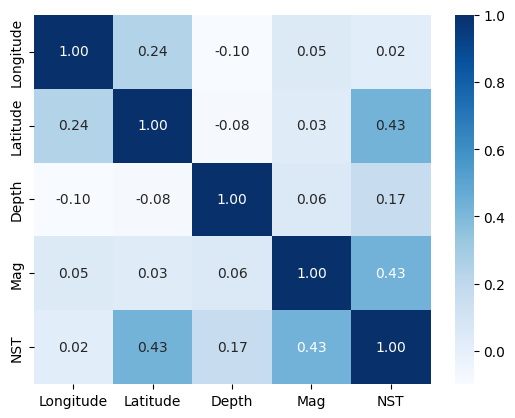

<Figure size 1000x800 with 0 Axes>

In [ ]:
correlacion = df_acp.corr()
sns.heatmap(correlacion, annot=True, cmap='Blues', fmt=".2f")
plt.figure(figsize=(10, 8))
plt.show()

---

## Creación del ACP


In [ ]:
scaler = StandardScaler()
df_acp_s = scaler.fit_transform(df_acp)

pca = PCA()
pca = pca.fit(df_acp_s)

### Varianzaexplicada por cada componente

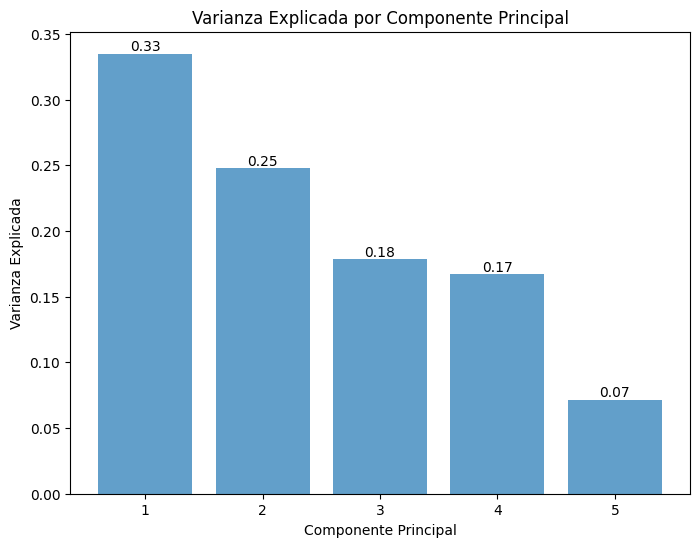

In [ ]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)

# Agregar etiquetas a las barras
for i, var_exp in enumerate(explained_variance):
    plt.text(i + 1, var_exp, f"{var_exp:.2f}", ha='center', va='bottom')


plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Componente Principal')
plt.show()

### PCA 2 componentes

In [ ]:
pca = PCA(n_components = 2)
pca = pca.fit(df_acp_s)

In [ ]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(2)], index = df_acp.columns)
print("Cargas de variables en los componentes:")
print(loadings)

Cargas de variables en los componentes:
                PC1       PC2
Longitude  0.227033 -0.580553
Latitude   0.512819 -0.413907
Depth      0.112904  0.597452
Mag        0.476800  0.313836
NST        0.667373  0.190257


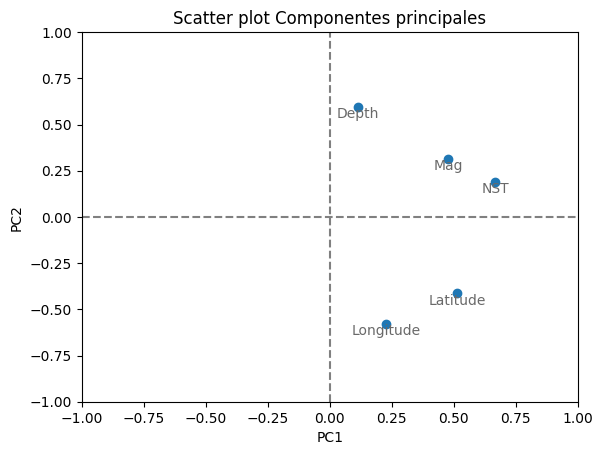

In [ ]:
plt.scatter(loadings['PC1'],loadings['PC2'] )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter plot Componentes principales')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Agregar etiquetas a cada punto
for label, x, y in zip(loadings.index, loadings['PC1'], loadings['PC2']):
    plt.text(x, y, label, ha='center', va='top', color = 'dimgray')

# Agregar líneas punteadas en y = 0 y x = 0
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

# Mostrar el gráfico
plt.show()

### PCA 3 componentes

In [ ]:
# Aplicar PCA
pca = PCA(n_components=3)
pca_result = pca.fit(df_acp)

In [ ]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(3)], index = df_acp.columns)
print("Cargas de variables en los componentes:")
print(loadings)

Cargas de variables en los componentes:
                PC1       PC2       PC3
Longitude  0.007481  0.787011  0.614670
Latitude   0.070122  0.074787 -0.011931
Depth      0.284545 -0.590032  0.754840
Mag        0.001071  0.000305 -0.000204
NST        0.956065  0.163962 -0.228591


In [ ]:
# Obtener las coordenadas de las variables en el espacio PCA
loadings = pca.components_.T  # Componentes de carga (loadings)
var_names = VariablesACP       # Nombres de las variables

# Crear un gráfico 3D para las variables
fig = go.Figure()

# Agregar vectores para cada variable
for i, var in enumerate(var_names):
    fig.add_trace(go.Scatter3d(
        x=[0, loadings[i, 0]],  # Desde el origen hasta la carga en PC1
        y=[0, loadings[i, 1]],  # Desde el origen hasta la carga en PC2
        z=[0, loadings[i, 2]],  # Desde el origen hasta la carga en PC3
        mode="lines+text",
        text=[var, var],  # Etiquetas de las variables
        textposition="top center",
        line=dict(width=4),
        name=var
    ))

# Configurar el diseño
fig.update_layout(
    title="PCA 3D - Variables",
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Mostrar el gráfico
fig.show()

### Visualización resultados

---

In [ ]:
#pca = PCA(n_components=2)
Y = pca.fit_transform(df_acp_s)
acp_df = pd.DataFrame(Y)
acp_df.rename(columns={0:"PC1",1:"PC2"},inplace=True)
df_acp_2 = pd.concat([df, acp_df],axis=1)

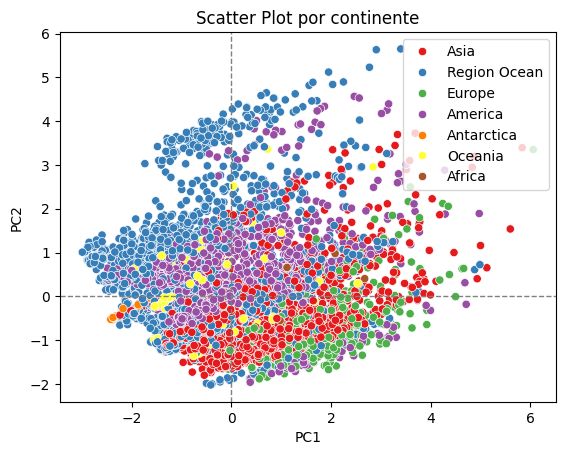

In [ ]:
sns.scatterplot(data=df_acp_2, x='PC1', y='PC2', hue='Continent', palette='Set1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot por continente')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

plt.legend()
plt.show()

In [ ]:
print(pca.components_)

[[ 0.22703288  0.51281919  0.11290394  0.47679964  0.66737347]
 [-0.58055295 -0.41390689  0.59745168  0.31383624  0.19025681]]
